In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path as P
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
from collections import defaultdict
import plotly.express as px
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras

In [18]:
learning_rate=0.001
train_size=0.8
seqlen=12
bs=32
epochs=200

这些是模型的超参数。
- learning_rate 是学习率，控制模型收敛的快慢，太大了模型容易发散，太小了模型收敛很慢；
- train_size 训练集占整个数据集的比例，一般是28开；
- seqlen：序列长度，在时序建模中，就是用前几个样本来预测当前样本；
- bs：batch size，批量大小，随机梯度下降算法SGD中，每次用来估计梯度的训练样本数量；
考虑到数据集本身只有100多个样本，批量不用太大；
- epochs：训练的轮数，即迭代次数；

In [19]:
df=pd.read_csv('问题2-训练数据-归一化.csv',index_col='time')

In [20]:
df_train, df_val = train_test_split(df, train_size=train_size, shuffle=True)

将数据集分割为训练集和验证集，二者没有交集，训练集用来训练模型，验证集用来确保模型没有过拟合。

In [21]:
feature_size=df_train.shape[1]
df_train.shape, df_val.shape

((98, 6), (25, 6))

In [22]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    df_train.values, df_train.values, sequence_length=seqlen, batch_size=bs)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    df_val.values, df_val.values, sequence_length=seqlen, batch_size=bs)

利用keras的接口构造时序模型需要的时序数据集。

In [23]:
dataset_train, dataset_val

(<BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>)

构建一个单层的LSTM模型。LSTM是一种专门用来建模时序数据的神经网络模型，即长短期记忆（Long Short Term Memory）。
可以展开说说理论。

In [24]:
inputs = keras.layers.Input(shape=(seqlen, feature_size))
lstm_out = keras.layers.LSTM(4)(inputs)
lstm_out = keras.layers.Dropout(0.1)(lstm_out)
outputs = keras.layers.Dense(feature_size)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 4)                 176       
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 6)                 30        
                                                                 
Total params: 206
Trainable params: 206
Non-trainable params: 0
_________________________________________________________________


训练模型：
1. 使用的损失函数：MSE，Mean Square Error，即均方误差；
2. 早停止：当验证误差经过一段时间不再改进之后，停止训练模型，这是一种停止训练循环的策略；
3. 检查点：当验证误差出现改进时，保存当前的模型参数；

In [25]:
path_checkpoint = "problem2_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    # 要同时保存网络结构。
    save_weights_only=False,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/200
1/3 [=========>....................] - ETA: 3s - loss: 0.2914
Epoch 1: val_loss improved from inf to 0.41713, saving model to problem2_checkpoint.h5
3/3 [==============================] - 2s 242ms/step - loss: 0.2844 - val_loss: 0.4171
Epoch 2/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2691
Epoch 2: val_loss improved from 0.41713 to 0.39975, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.2639 - val_loss: 0.3998
Epoch 3/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2586
Epoch 3: val_loss improved from 0.39975 to 0.38364, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 101ms/step - loss: 0.2517 - val_loss: 0.3836
Epoch 4/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2451
Epoch 4: val_loss improved from 0.38364 to 0.36877, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 62ms/step - loss: 0.2425 - val_loss: 0.368

3/3 [==============================] - 0s 67ms/step - loss: 0.1135 - val_loss: 0.1879
Epoch 34/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1171
Epoch 34: val_loss improved from 0.18787 to 0.18450, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 65ms/step - loss: 0.1119 - val_loss: 0.1845
Epoch 35/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1143
Epoch 35: val_loss improved from 0.18450 to 0.18116, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 63ms/step - loss: 0.1082 - val_loss: 0.1812
Epoch 36/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1100
Epoch 36: val_loss improved from 0.18116 to 0.17785, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 66ms/step - loss: 0.1057 - val_loss: 0.1778
Epoch 37/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1135
Epoch 37: val_loss improved from 0.17785 to 0.17459, saving model to problem2_ch

1/3 [=========>....................] - ETA: 0s - loss: 0.0767
Epoch 66: val_loss improved from 0.10245 to 0.10119, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0686 - val_loss: 0.1012
Epoch 67/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0711
Epoch 67: val_loss improved from 0.10119 to 0.10005, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0629 - val_loss: 0.1000
Epoch 68/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0654
Epoch 68: val_loss improved from 0.10005 to 0.09896, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 58ms/step - loss: 0.0599 - val_loss: 0.0990
Epoch 69/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0684
Epoch 69: val_loss improved from 0.09896 to 0.09796, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0636 - val_loss: 0.0980
E

3/3 [==============================] - 0s 62ms/step - loss: 0.0592 - val_loss: 0.0899
Epoch 99/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0695
Epoch 99: val_loss improved from 0.08990 to 0.08981, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0606 - val_loss: 0.0898
Epoch 100/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0648
Epoch 100: val_loss improved from 0.08981 to 0.08973, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 68ms/step - loss: 0.0581 - val_loss: 0.0897
Epoch 101/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0680
Epoch 101: val_loss improved from 0.08973 to 0.08970, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 89ms/step - loss: 0.0613 - val_loss: 0.0897
Epoch 102/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0618
Epoch 102: val_loss improved from 0.08970 to 0.08963, saving model to probl

对模型训练过程的损失函数和验证损失函数进行可视化。
- 基于matplotlib的可视化；
- 基于plotly的可视化；

挑一个好看的就行。

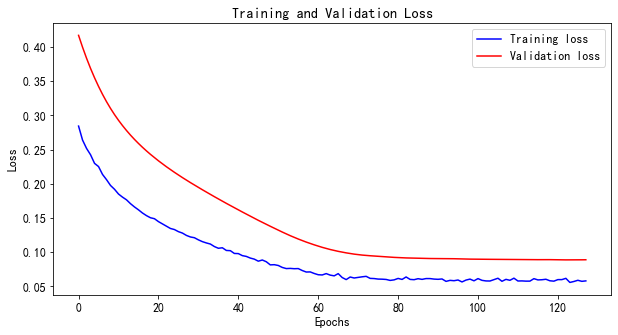

In [26]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

In [27]:
def visualize_loss_px(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    df=pd.DataFrame(data={'Training loss': loss, 'Validation loss': val_loss})
    return px.line(df, y=df.columns).update_layout(xaxis_title='Epochs', yaxis_title='Loss',legend_title='',title=title)

visualize_loss_px(history, "Training and Validation Loss")